In [1]:
import librosa
import librosa.display

Populating the interactive namespace from numpy and matplotlib
(173, 40)


array([-186.29369  ,  111.83632  ,  -47.335823 ,   16.292126 ,
        -17.449097 ,    7.793613 ,  -17.645851 ,    9.319144 ,
        -17.199574 ,    3.937947 ,  -19.640718 ,   -1.0967298,
        -15.500124 ,   -1.1180016,  -14.3115   ,   -2.2991726,
        -13.424973 ,   -0.5971485,   -9.997926 ,   -3.033559 ,
        -11.0444355,   -3.943905 ,   -8.028481 ,   -4.065942 ,
        -10.109748 ,   -3.0896254,   -7.573358 ,   -5.9907274,
         -9.764758 ,   -4.2451377,   -4.8508115,   -4.606578 ,
         -6.7040167,   -3.5499804,   -3.6824217,   -4.478353 ,
         -4.381412 ,   -1.7015086,   -3.7670383,   -4.4581046],
      dtype=float32)

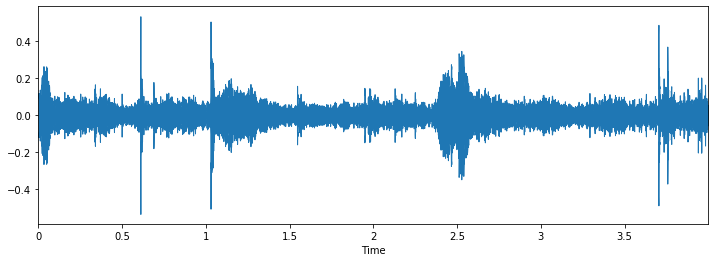

In [2]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

data, sampling_rate = librosa.load('data/train/Train/2022.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

X, sample_rate = librosa.load('data/train/Train/2022.wav', res_type='kaiser_fast') 
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T
print(mfcc.shape)
np.mean(mfcc, axis=0)

In [3]:

train = pd.read_csv("data/train/train.csv") 

In [4]:
test = pd.read_csv("data/test/test.csv") 

In [5]:
train.Class.value_counts()


jackhammer          668
engine_idling       624
siren               607
dog_bark            600
street_music        600
children_playing    600
drilling            600
air_conditioner     600
car_horn            306
gun_shot            230
Name: Class, dtype: int64

## Load audio files and extract features

In [6]:
data_dir = "data/"
def parser(row):
   # function to load files and extract features
   file_name = os.path.join(os.path.abspath(data_dir), 'train/Train', str(row.ID) + '.wav')

   # handle exception to check if there isn't a file which is corrupted
   try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
   except Exception as e:
      print("Error encountered while parsing file: ", file)
      return None, None
 
   feature = mfccs
   label = row.Class
 
   return pd.Series([feature, label], index=['feature', 'label'])

temp = train.apply(parser, axis=1)
temp.columns = ['feature', 'label']

## Convert the data to pass it in our deep learning model

In [7]:
temp

,feature,label
0,"[-82.12359, 139.50595, -42.430847, 24.82786, -...",siren
1,"[-15.744001, 124.11996, -29.42888, 39.44719, -...",street_music
2,"[-123.393654, 15.181944, -50.093338, 7.141871,...",drilling
3,"[-213.2787, 89.323616, -55.256165, 12.632097, ...",siren
4,"[-237.9265, 135.90247, 39.26844, 21.24023, 9.5...",dog_bark
...,...,...
5430,"[-214.65845, 178.94125, -1.2636192, 63.962276,...",engine_idling
5431,"[-395.34586, 105.81336, -0.19628958, -7.097910...",dog_bark
5432,"[-320.81738, 58.30057, -6.869504, 15.693741, -...",engine_idling
5433,"[-277.0318, 141.1457, -36.32912, 39.455746, -0...",engine_idling


In [8]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

X = np.array(temp.feature.tolist())
y = np.array(temp.label.tolist())

lb = LabelEncoder()

y = np_utils.to_categorical(lb.fit_transform(y))

Using TensorFlow backend.


# Run a deep learning model and get results

In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación

X_train, X_test, y_train, y_test = train_test_split(X, y)

num_labels = y.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                2570      
__________

In [20]:
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

Train on 4076 samples, validate on 1359 samples
Epoch 1/100
4076/4076 [==============================] - 1s 322us/step - loss: 1.7775 - acc: 0.4271 - val_loss: 1.5206 - val_acc: 0.5570
Epoch 2/100
4076/4076 [==============================] - 1s 330us/step - loss: 1.5984 - acc: 0.4750 - val_loss: 1.3780 - val_acc: 0.5843
Epoch 3/100
4076/4076 [==============================] - 1s 305us/step - loss: 1.4733 - acc: 0.5091 - val_loss: 1.2824 - val_acc: 0.6122
Epoch 4/100
4076/4076 [==============================] - 1s 291us/step - loss: 1.3965 - acc: 0.5420 - val_loss: 1.2405 - val_acc: 0.6306
Epoch 5/100
4076/4076 [==============================] - 1s 349us/step - loss: 1.3024 - acc: 0.5694 - val_loss: 1.1148 - val_acc: 0.6446
Epoch 6/100
4076/4076 [==============================] - 1s 330us/step - loss: 1.2618 - acc: 0.5792 - val_loss: 1.0953 - val_acc: 0.6806
Epoch 7/100
4076/4076 [==============================] - 1s 331us/step - loss: 1.2167 - acc: 0.5895 - val_loss: 1.0510 - val_acc: 

4076/4076 [==============================] - 1s 210us/step - loss: 0.5493 - acc: 0.8182 - val_loss: 0.4891 - val_acc: 0.8514
Epoch 61/100
4076/4076 [==============================] - 1s 207us/step - loss: 0.5160 - acc: 0.8236 - val_loss: 0.4679 - val_acc: 0.8595
Epoch 62/100
4076/4076 [==============================] - 1s 210us/step - loss: 0.5205 - acc: 0.8273 - val_loss: 0.4798 - val_acc: 0.8484
Epoch 63/100
4076/4076 [==============================] - 1s 215us/step - loss: 0.5391 - acc: 0.8209 - val_loss: 0.4677 - val_acc: 0.8595
Epoch 64/100
4076/4076 [==============================] - 1s 213us/step - loss: 0.5415 - acc: 0.8192 - val_loss: 0.4754 - val_acc: 0.8484
Epoch 65/100
4076/4076 [==============================] - 1s 226us/step - loss: 0.5208 - acc: 0.8192 - val_loss: 0.4575 - val_acc: 0.8617
Epoch 66/100
4076/4076 [==============================] - 1s 204us/step - loss: 0.4922 - acc: 0.8334 - val_loss: 0.4573 - val_acc: 0.8639
Epoch 67/100
4076/4076 [=======================